# Blood Transfusion Donations

## About Dataset

This blood donation dataset came from the UCI repository. They provide a wide range of datasets for testing machine learning algorithms. Finding a subject matter you're interested in can be a great way to test yourself on real-world data problems. Given our mission, we're interested in predicting if a blood donor will donate within a given time window.

Use information about each donor's history

* Months since Last Donation: this is the number of monthis since this donor's most recent donation.

* Number of Donations: this is the total number of donations that the donor has made.
Total Volume Donated: this is the total amound of blood that the donor has donated in cubuc centimeters.

* Months since First Donation: this is the number of months since the donor's first donation.
Submission format

This competitions uses log loss as its evaluation metric, so the predictions you submit are the probability that a donor made a donation in March 2007.

# Task


Predict if the donor will give in March 2007
The goal is to predict the last column, whether he/she donated blood in March 2007 with log-probabilities. Build out multiple classifiers with a variety of models, with validation, and keep track of the scores and performances via a pandas dataframe and writeout to csv. 



# Loading Data

In [60]:
import numpy as np 
import pandas as pd 
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pprint
import os
from timeit import default_timer
from sklearn.decomposition import PCA 
from google.colab import drive
from sklearn.metrics import (classification_report, 
 f1_score, accuracy_score, 
 recall_score, precision_score, 
 roc_auc_score,
 confusion_matrix)
from sklearn.model_selection import train_test_split, GridSearchCV

FILENAME = "/content/drive/My Drive/problem_set_challenges_for_job_postings/transfusion.data"
DRIVE = "/content/drive/"

drive.mount(DRIVE)
df = pd.read_csv(FILENAME, header="infer")
df.rename(columns={"whether he/she donated blood in March 2007" : "target"}, inplace=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Exploratory Data Analysis

## Quick profilling with Pandas Profiler

What can be gleened:

* data not normally distributed
* nice and clean and little to no preprocessing is required for this dataset
* no encoding needed
* no missing values
* all numeric variables and one binary target attribute
* one highly correlated feature rejected
    * Amount of blood is highly correlated with the Frequency (times) attribute and the frequency column is rejected
* We will have to drop the frequency column
* the majority of values are non-zero

In [6]:
report = pandas_profiling.ProfileReport(df)
report

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,5
Number of observations,748
Total Missing (%),0.0%
Total size in memory,29.3 KiB
Average record size in memory,40.2 B
Numeric,3
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


## Quick Distribution plotting

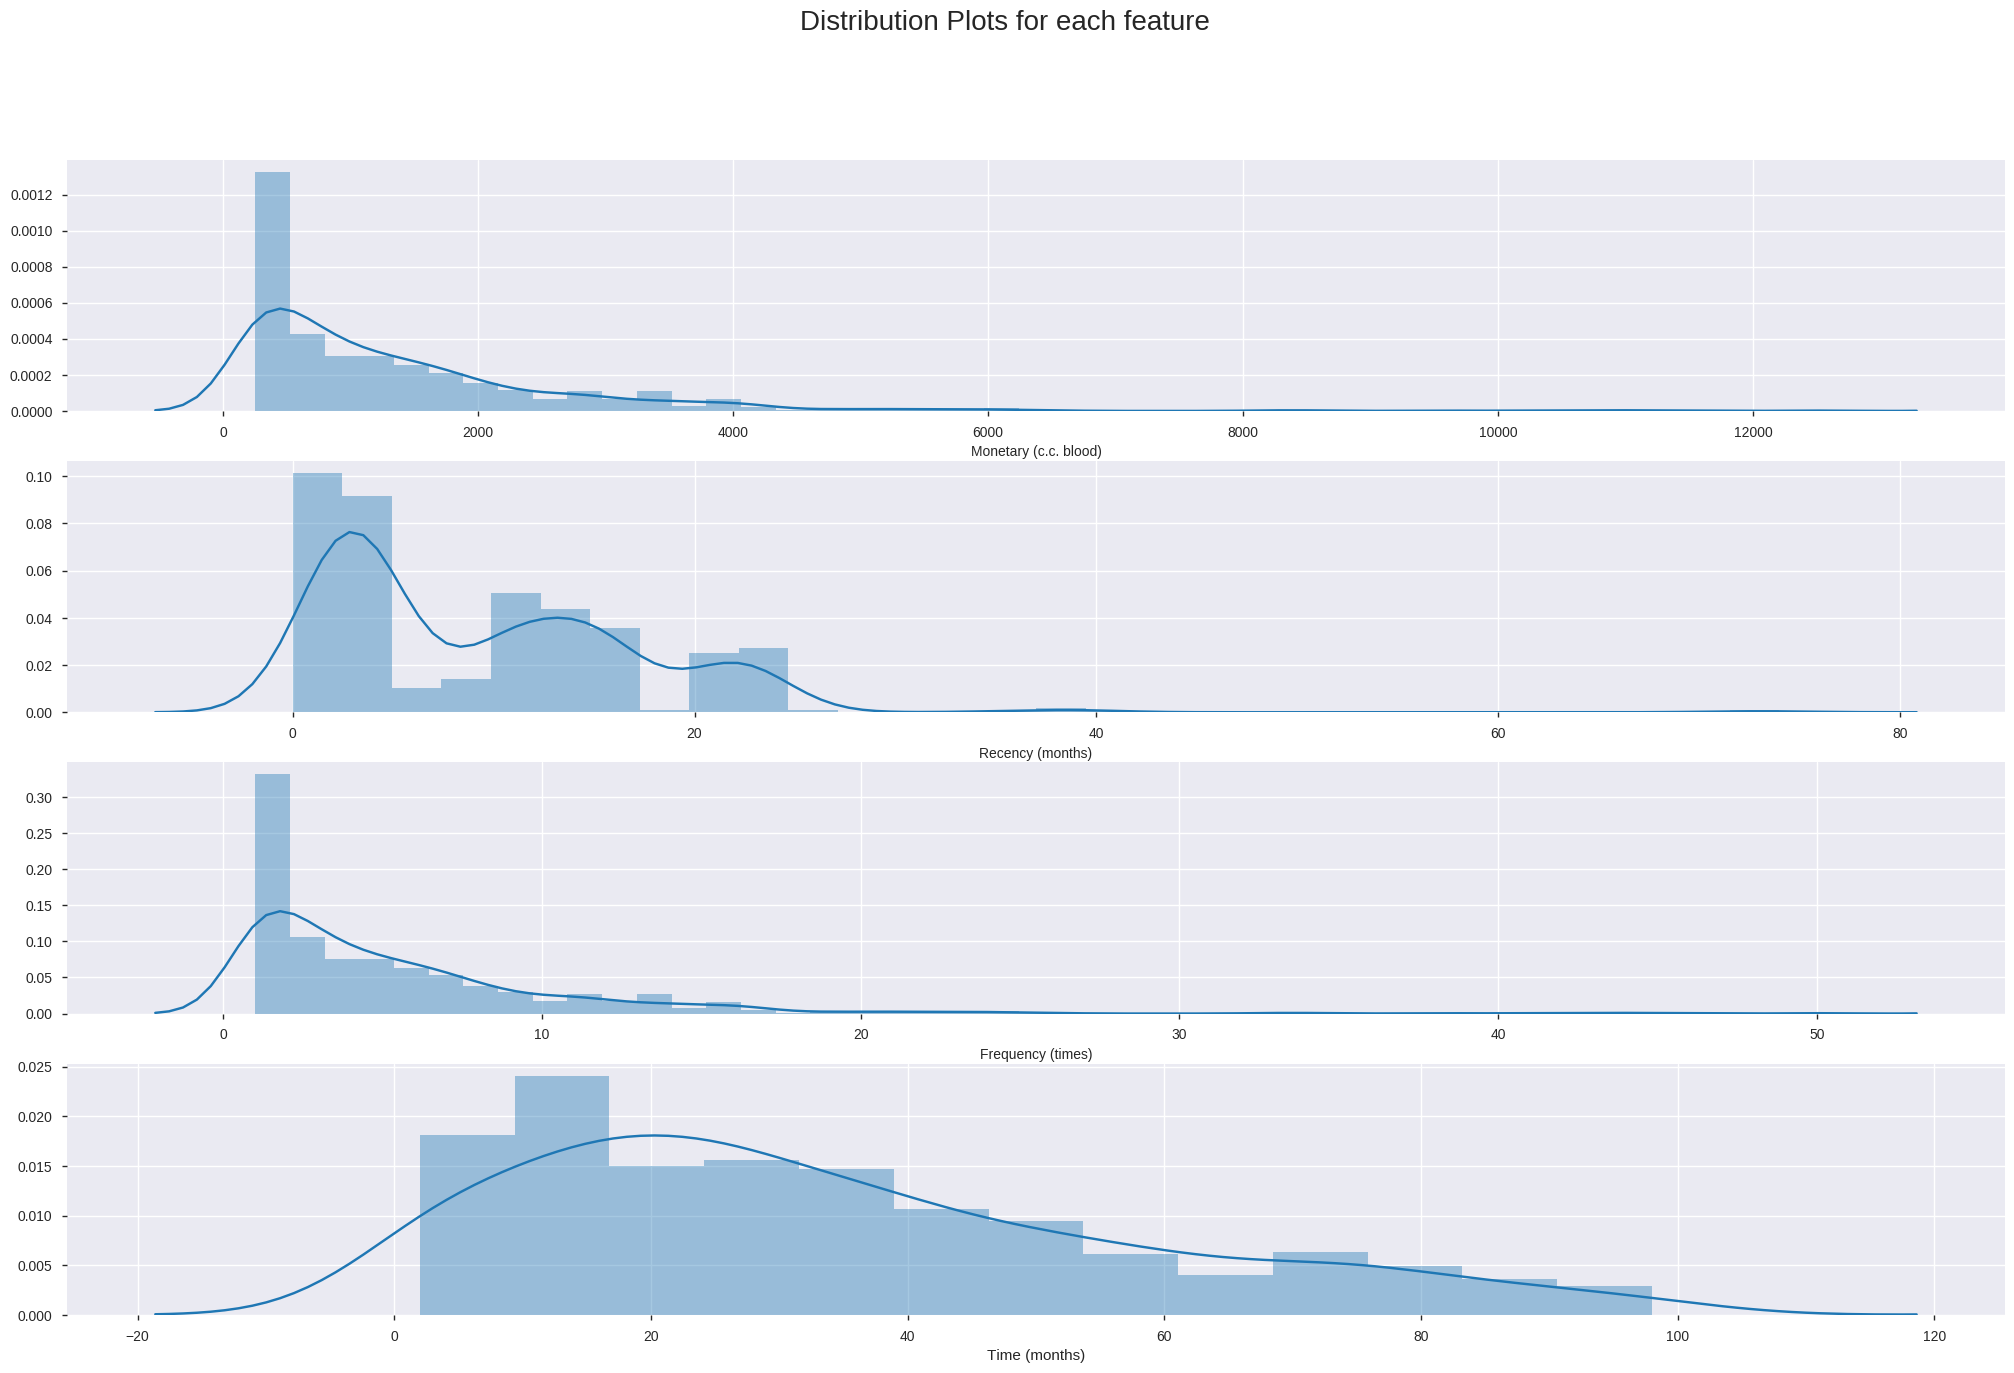

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(25, 15))
fig.suptitle('Distribution Plots for each feature', fontsize=20)
sns.distplot(df['Monetary (c.c. blood)'], hist=True, norm_hist=True, ax=ax1)
ax1.set_xlabel('Monetary (c.c. blood)', fontsize=10)
sns.distplot(df['Recency (months)'], hist=True, norm_hist=True, ax=ax2)
ax2.set_xlabel('Recency (months)', fontsize=10)
sns.distplot(df['Frequency (times)'], hist=True, norm_hist=True, ax=ax3)
ax3.set_xlabel('Frequency (times)', fontsize=10)
sns.distplot(df['Time (months)'], hist=True, norm_hist=True, ax=ax4)
plt.show()

## Quick histogram plotting

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5191cc7828>,
      dtype=object)

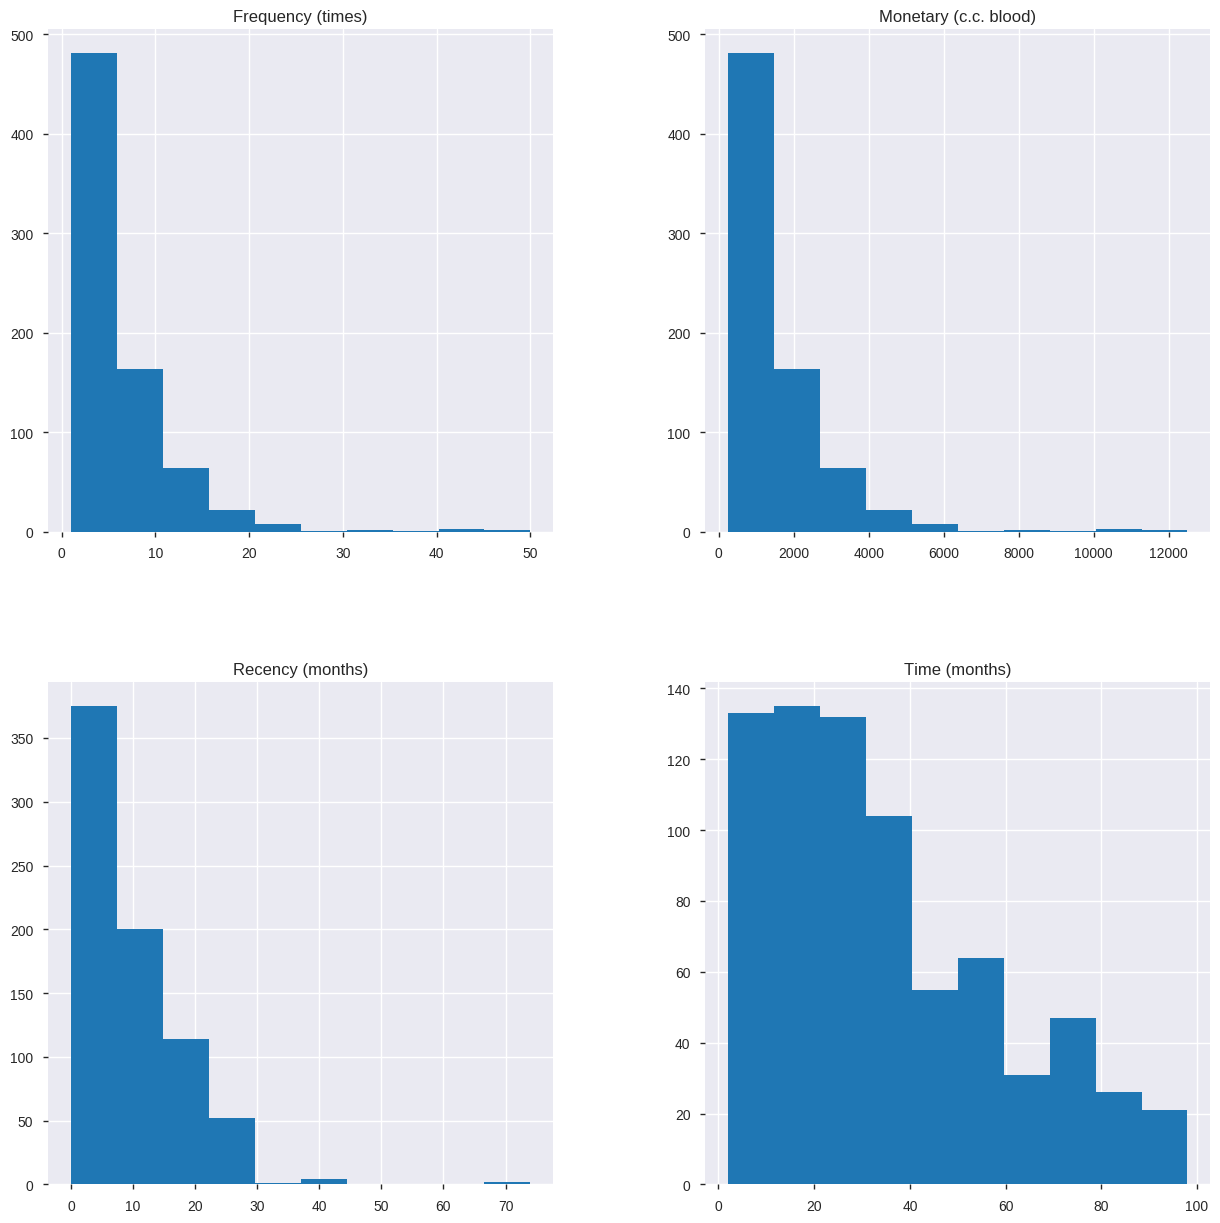

In [8]:
pd.DataFrame.hist(df.iloc[:, :-1], figsize = [15,15])

## Drop highly correlated variables

In [0]:
df.drop('Frequency (times)', axis=1, inplace=True)

## Feature selection

### Variance Threshold Feature Selection

In [10]:
def select_features_var_threshold(dataframe, threshold):
    """ Features with a training-set variance lower than this threshold will be removed.  """
    from sklearn.feature_selection import VarianceThreshold
    from timeit import default_timer

    X, y = dataframe.iloc[:, :-1].values, dataframe.iloc[:, -1].values
    start = default_timer()
    var_threshold = VarianceThreshold(threshold)
    var_threshold.fit(X)
    X_new = var_threshold.transform(X)
    end = default_timer()
    print("Elapsed Time for feature selection: {}s".format(end-start))
    return X_new

new_selected_features = select_features_var_threshold(df, threshold=0.7)
print(f"Variance Thresheld Selected Features: {new_selected_features}")

Elapsed Time for feature selection: 0.00040533799983677454s
Variance Thresheld Selected Features: [[    2 12500    98]
 [    0  3250    28]
 [    1  4000    35]
 ...
 [   23   750    62]
 [   39   250    39]
 [   72   250    72]]


Using variance threshold feature selection, with a threshold of 0.7, our feature selection class kept all the features and the RandomForestClassifier returned the same scores as it out have produced without the feature selection, out of the box.

The R-squared coefficient is 0.92+ which is really high, which means that this model does really well out of the box. Because the number of feature in this dataset are so little, we decide to just keep all the features in the dataset.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from timeit import default_timer

dataframe = pd.DataFrame(new_selected_features)
X = df.iloc[:, :-1].values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

rfc = RandomForestClassifier()
start = default_timer()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("coefficient of determination R^2 of our estimator out of the box: {}".format(rfc.score(X_train, y_train)))
end = default_timer()
print("Total training time: {}s".format(end-start))

coefficient of determination R^2 of our estimator out of the box: 0.9235181644359465
Total training time: 0.023605881000548834s


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
from sklearn.metrics import confusion_matrix as cm
cm = cm(y_test, y_pred, labels=None, sample_weight=None)
cm

array([[144,  21],
       [ 42,  18]])

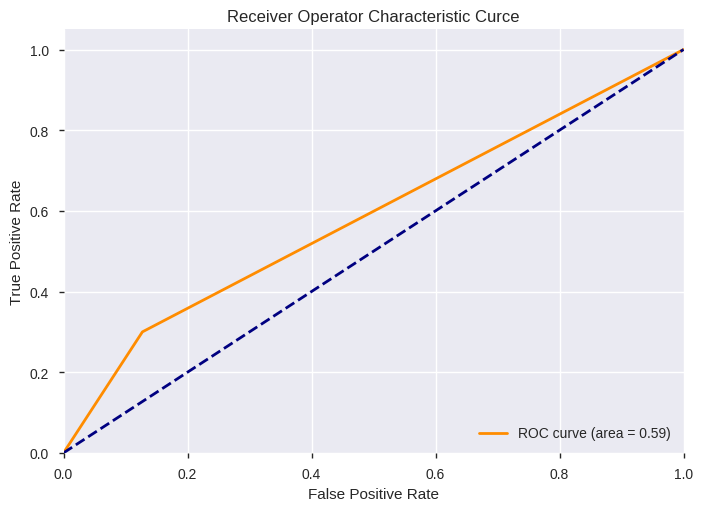

In [13]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curce')
plt.legend(loc="lower right")
plt.show()

We also find out from this ROC curve, that after our feature selection, we had built a simple Random Forest Classifier that achieved performance little better than a null model...This does not say a lot about our modeling process and that perhaps further testing, modeling and experimentation is in order. But at least we know out of the box, we can see that this problem might be more involved than we had thought at onset.

-----------------------------------------------------------------
_________________________________________________________________

## Hypothesis testing

I want to perform a little bit more data exploration and statistical testing of hypothesis testing to see whether or not a strong statistical relationship exists between dependent and independent variables. After having plotted the distribution of each of the feature values, we know that we are dealing with a non-normal distribution and therefore a non-parametric approach to hypothesis testing must be pursued.

From the Kruskal Wallis test, we can see that there is a difference in the median  Recency and the total blood donated values, for those who have donated their blood in March 2007 and those who did not. There is, however, no difference between the donor and non-donor groups in terms of the months since last donation (as time since last donatio is intuitively independent).

In [14]:
from scipy.stats import kruskal

for col in df.columns[df.columns != "target"]:
    print("{}: {}".format(col, kruskal(df.loc[df.target==1, col],
                            df.loc[df.target ==0, col])))

Recency (months): KruskalResult(statistic=65.28504036601454, pvalue=6.48114733861018e-16)
Monetary (c.c. blood): KruskalResult(statistic=35.10221854273894, pvalue=3.128441735961902e-09)
Time (months): KruskalResult(statistic=0.5894765141978687, pvalue=0.4426216188460801)


## Dimensionality Reduction with PCA

Best parameter (CV score=0.675):
{'logistic__alpha': 10000.0, 'pca__n_components': 1}


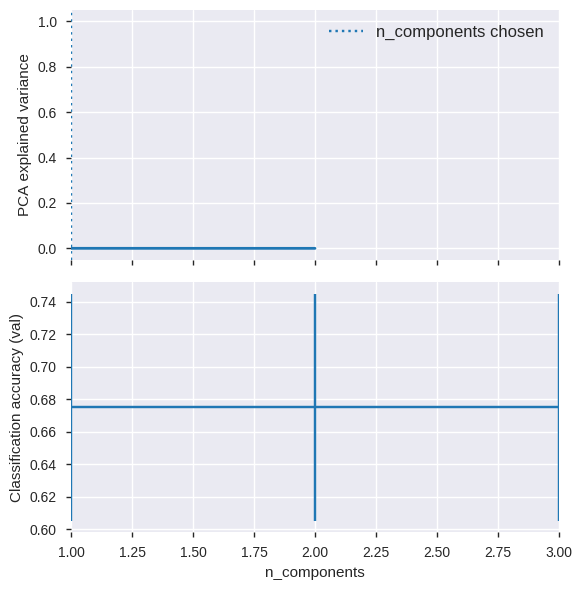

In [15]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X = df.iloc[:, :-1].values
y = df['target'].values

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [1, 2, 3],
    'logistic__alpha': np.logspace(-4, 4, 5),
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=10)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()

Dimensionality reduction with PCA reveals that only 1 principal component was chosen to explain the most variance. We, however, will not be using any principal components then for modeling our data, because that gives us too little information.

## Prep the data for modelling

In [0]:
from sklearn.model_selection import train_test_split
from timeit import default_timer

dataframe = pd.DataFrame(new_selected_features)

features = df.iloc[:, :-1].values
target = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [0]:
# scaled features
from sklearn.preprocessing import StandardScaler

scaled_features = StandardScaler().fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.3, random_state=123)
y_train = y_train.ravel()
y_test = y_test.ravel()

## Null Models

Feed the data into a bunch of basic, classic machine learning models right out of the box, with some parameter optimization. We just want to see what we can get out of the box with some of the basic algorithms before going beyond further.

In [0]:
model_performance_df = pd.DataFrame()
model_ids = []
model_type = []
model_parameters = []
model_evaluation_metrics = []
model_score = []

### Logistic Regression Classifier

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score, f1_score, classification_report

# model = LogisticRegression(solver='saga')

param_grid = {"penalty": ["l1", "l2", "elasticnet"],
              "C": np.arange(0., 1.1, 0.1)}

start = default_timer()

gscv = GridSearchCV(estimator=LogisticRegression(solver='saga'), 
                    param_grid=param_grid, 
                    scoring="balanced_accuracy",
                    cv=10,
                    refit=True,
                    error_score=np.nan)

gscv.fit(X_train, y_train)

y_pred = gscv.predict(X_test)
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gscv.score(X_train, y_train)))
end = default_timer()
print("Total training time: {}s".format(end-start))

In [20]:
# list of model attributes you print out
print("Best Estimator: \n{}\nBest Score: \n{}\nBest Params: \n{}\nScorer: \n{}".format(
gscv.best_estimator_, 
gscv.best_score_, 
gscv.best_params_, 
gscv.scorer_))

Best Estimator: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Best Score: 
0.5582485596062288
Best Params: 
{'C': 1.0, 'penalty': 'l2'}
Scorer: 
make_scorer(balanced_accuracy_score)


In [21]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
cr = classification_report(y_test, y_pred)
pp.pprint(cr)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.74      0.98      0.84       165\n'
 '           1       0.50      0.07      0.12        60\n'
 '\n'
 '    accuracy                           0.73       225\n'
 '   macro avg       0.62      0.52      0.48       225\n'
 'weighted avg       0.68      0.73      0.65       225\n')


### Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {"n_estimators": [5, 10, 20],
              "max_depth": [3, 4, 5], 
              "min_samples_leaf": [1, 2, 3, 4, 5]}


gscv_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=123, verbose=0, warm_start=True), 
                    param_grid=param_grid, 
                    scoring="balanced_accuracy",
                    cv=10,
                    refit=True,
                    error_score=np.nan)

start = default_timer()
gscv_rfc.fit(X_train, y_train)
y_pred = gscv_rfc.predict(X_test)
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gscv_rfc.score(X_train, y_train)))
end = default_timer()
print("Total training time: {}s".format(end-start))

coefficient of determination R^2 of our estimator out of the box: 0.6919439213224524
Total training time: 7.540801600999657s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
# random forest classifier class attributes

print("Best Estimator: \n{}\nBest Score: \n{}\nBest Params: \n{}\nScorer: \n{}".format(
gscv_rfc.best_estimator_, 
gscv_rfc.best_score_, 
gscv_rfc.best_params_, 
gscv_rfc.scorer_))

Best Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=True)
Best Score: 
0.6148481739467142
Best Params: 
{'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 5}
Scorer: 
make_scorer(balanced_accuracy_score)


In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[152,  13],
       [ 44,  16]])

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       165
           1       0.55      0.27      0.36        60

    accuracy                           0.75       225
   macro avg       0.66      0.59      0.60       225
weighted avg       0.72      0.75      0.71       225



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.34')

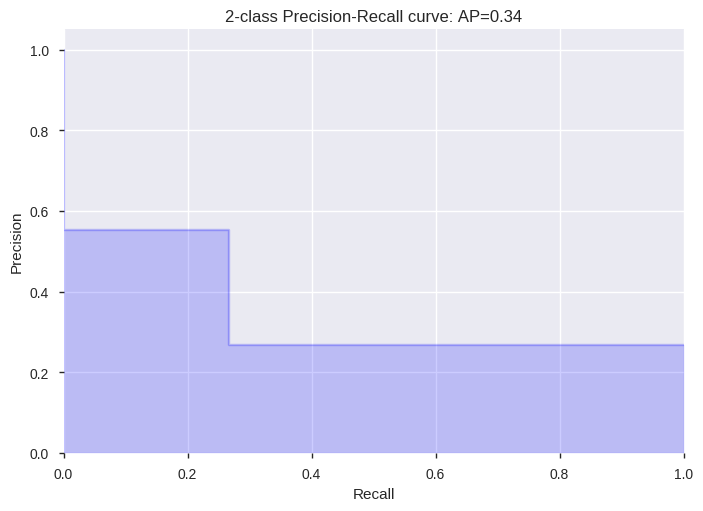

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from inspect import signature

average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [29]:
df.target.value_counts()

0    570
1    178
Name: target, dtype: int64

From these null models (with a teensy bit of hyperparameter space searching), we can see that, given the imbalance in the class sizes, we were not able to get a model with a considerably good predictive accuracy score ( lots of negative cases compared to positive cases). We also did not achieve good recall, precision or f-1 scores. Therefore, our other unexplored option would be to employ synthetic data generation through over-sampling of the minority class.

## Over Sampling of Minority class to over come class imbalance

In [0]:
!pip install imbalanced-learn -qq

In [0]:
# imbalanced learn processor
from imblearn.over_sampling import SMOTE

def over_sampler(features, target):
    """ use grid search to pick best neighbors for 
    resampler via modeling after resampler and selecting best model
    
    :param features: scaled features
    :param target: target is not scaled
    
     """
    from imblearn.over_sampling import SMOTE

    sm = SMOTE(random_state=42, k_neighbors=21)
    features_res, target_res = sm.fit_resample(features, target)
    return features_res, target_res

In [0]:
features_res, target_res = over_sampler(scaled_features, df.iloc[:, -1].values)

In [51]:
from timeit import default_timer

X_train, X_test, y_train, y_test = train_test_split(features_res, target_res, train_size=0.3, random_state=42)

param_grid = {"n_estimators": [40, 42, 43, 45, 50],
              "max_depth": [3, 4, 5], 
              "min_samples_leaf": [1, 2, 3, 4, 5]}


gv = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
start_time = default_timer()
gv.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
end_time = default_timer()
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gv.score(X_train, y_train)))
print("ROC AUC score: {}".format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Best Estimator: {}".format(gv.best_estimator_))
print("Time to train: {}s".format(end_time - start_time))

coefficient of determination R^2 of our estimator out of the box: 0.8333333333333334
ROC AUC score: 0.7353878051079069
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       405
           1       0.79      0.64      0.71       393

    accuracy                           0.74       798
   macro avg       0.75      0.74      0.73       798
weighted avg       0.74      0.74      0.73       798

Accuracy Score: 0.7368421052631579
F1 Score: 0.7050561797752809
Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
model_ids = []
best_estimators = []
best_parameters = []
precision = []
recall = []
accuracy = []
roc_auc = []
r2 = []

model_ids.append("001")
best_estimators.append(gv.best_estimator_)
best_parameters.append(gv.best_params_)
precision.append(precision_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_pred))
r2.append(gv.score(X_test, y_test))

best_models_df = pd.DataFrame()
best_models_df['id'] = model_ids
best_models_df['best_estimator'] = best_estimators
best_models_df['best_parameters'] = best_parameters
best_models_df['accuracy'] = accuracy
best_models_df['precision'] = precision
best_models_df['recall'] = recall
best_models_df['roc_auc'] = roc_auc
best_models_df['r2_score'] = r2

In [55]:
best_models_df.head()

,id,estimator,best_parameters,accuracy,precision,recall,roc_auc,r2_score
0,001,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.736842,0.786834,0.638677,0.735388,0.723058


In [56]:
from sklearn.metrics import confusion_matrix as cm
cm = cm(y_test, y_pred, labels=None, sample_weight=None)
cm

array([[337,  68],
       [142, 251]])

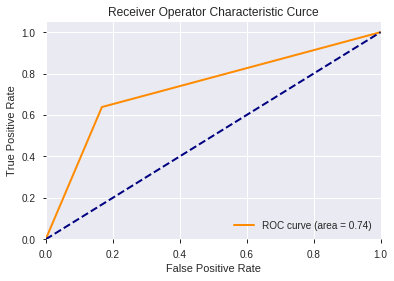

In [57]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curce')
plt.legend(loc="lower right")
plt.show()

With some scaling and class balancing, we are able to improve our model's performance in terms of AUC score with a simple random forest classifier. Let's try out a few other simple classifiers before we run the model selection with TPOT.

## XGBoost

In [0]:
!pip install xgboost -qq

In [0]:
from xgboost import XGBClassifier
from xgboost.callback import early_stop

X_train, X_test, y_train, y_test = train_test_split(features_res, target_res, train_size=0.3, random_state=42)

param_grid = {"n_estimators": [20, 40, 42, 43, 45, 50, 75, 80, 100],
              "learning_rate": [0.0001, 0.001, 0.01, 0.05],
              "max_depth": [3, 4, 5], 
              "booster": ["gbtree", "dart"],
              "reg_lambda": [0.4, 0.5, 0.7, 0.8, 0.9]
              }

gv_xgb = GridSearchCV(XGBClassifier(random_state=42, verbosity=1), param_grid, cv=10)
start_time = default_timer()
gv_xgb.fit(X_train, y_train, callbacks=[early_stop])
y_pred = gv_xgb.predict(X_test)
end_time = default_timer()

In [0]:
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gv_xgb.score(X_train, y_train)))
print("ROC AUC score: {}".format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Best Estimator: {}".format(gv_xgb.best_estimator_))
print("Time to train: {}s".format(end_time - start_time))

In [0]:
eval_results = gv_xgb.evals_result()
print(eval_results)
model_params = gv_xgb.get_xgb_params()
print(model_params)

In [0]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curce')
plt.legend(loc="lower right")
plt.show()

## AdaBoost Classifier

In [0]:
param_grid = {"n_estimators": [40, 42, 43, 45, 50],
              "max_depth": [3, 4, 5], 
              "min_samples_leaf": [1, 2, 3, 4, 5]}


gv = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
start_time = default_timer()
gv.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
end_time = default_timer()
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gv.score(X_train, y_train)))
print("ROC AUC score: {}".format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Best Estimator: {}".format(gv.best_estimator_))
print("Time to train: {}s".format(end_time - start_time))

In [0]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curce')
plt.legend(loc="lower right")
plt.show()

### LIME algorithm

In [62]:
!pip install lime -qq

     |████████████████████████████████| 276kB 4.9MB/s 


In [0]:
# model using LIME

param_grid = {"n_estimators": [40, 42, 43, 45, 50],
              "max_depth": [3, 4, 5], 
              "min_samples_leaf": [1, 2, 3, 4, 5]}


gv = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
start_time = default_timer()
gv.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
end_time = default_timer()
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gv.score(X_train, y_train)))
print("ROC AUC score: {}".format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Best Estimator: {}".format(gv.best_estimator_))
print("Time to train: {}s".format(end_time - start_time))

In [0]:
# Look at the feature imporances for interpretability with the LIME algorithm

In [0]:
# plot ROC curve of the LIME algorithm classification results
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curce')
plt.legend(loc="lower right")
plt.show()

## Model Selection and Evaluation Pipeline

In [59]:
# install feature selection and model selection pipeline libraries
!pip install mlxtend -qq
!pip install tpot -qq

     |████████████████████████████████| 901kB 5.2MB/s 
     |████████████████████████████████| 153kB 52.1MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 


### Model Selection using TPOT

In [25]:
from tpot import TPOTClassifier

tpot_classifier = TPOTClassifier(generations=50, population_size=100, cv=10, random_state=42, verbosity=1, memory='auto')

start_time = default_timer()
tpot_classifier.fit(X_train, y_train)
print("TPOT Score: {}".format(tpot_classifier.score(X_test, y_test)))
y_pred = tpot_classifier.predict(X_test)
end_time = default_timer()

runtime = end_time - start_time

print(f"Total runtime for the Employee dataset: {runtime}s")

tpot_regressor.export('tpot_exported_pipeline.py')



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: LogisticRegression(input_matrix, C=25.0, dual=False, penalty=l1)
TPOT Score: 0.7333333333333333
Total runtime for the Employee dataset: 5.059569226999997s


In [0]:
print("Best Estimator: \n{}\nBest Score: \n{}\nBest Params: \n{}\nScorer: \n{}".format(
gscv_rfc.best_estimator_, 
gscv_rfc.tpot_regressor.score, 
gscv_rfc.best_params_, 
gscv_rfc.scorer_))

Using the tpot pipeline generated in this section, we will load in the data again for this new optimized classifier. This will be done in a separate accompanying notebook.

In [0]:
# !mv tpot_exported_pipeline.py "./drive/My Drive/problem_set_challenges_for_job_postings"

In [0]:
break